In [75]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

In [76]:
# Get the df from before
%run mass_df.ipynb

Now you have the file massround.mas20.txt in the pd.DataFrame() -> df


In [85]:
float(df.query("A == 2")["Binding Energy/A (keV)"].values[0])*2

2224.566

In [286]:
def func(U_0: float, A: int) -> float:
    reduced_m_d = 469.48968  # MeV / c²
    bound_energy = df.query(f"A == {A}")["Binding Energy/A (keV)"].str.replace("#", "").astype(float).mean() * A * 1e-3  # MeV
    hbarc = 197.327  # MeV * fm
    R = 1.4 * A **(1/3)  # fm
    k1 = np.sqrt(2 * reduced_m_d * (U_0 - bound_energy)) / hbarc
    k2 = np.sqrt(2 * reduced_m_d * bound_energy) / hbarc
    output = 1 / k1 * np.tan(k1 * R) + 1 / k2
    return output

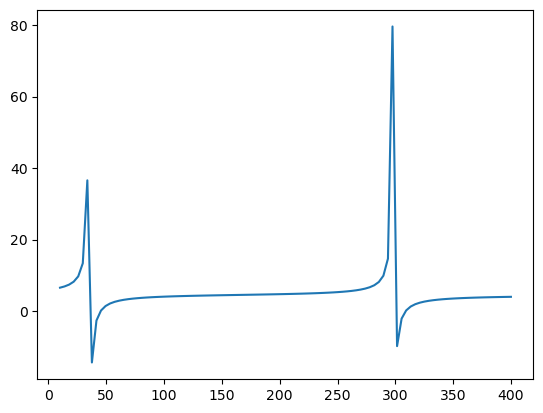

In [292]:
U_0s = np.linspace(10,400, 100)
plt.plot(U_0s, func(U_0s, 2))
#plt.xlim(40,50)
plt.show()

In [269]:
U_0_value = fsolve(func, 47, 2)[0]
U_0_value

45.15084885294296

In [92]:
def full_eq(r: float, U_0: float) -> float:
    reduced_m_d = 469.48968  # MeV/c²
    bound_energy = 2.2 # MeV Brug mass filen til at få denne energi ind
    hbarc = 197.327 # MeV*fm
    R = 1.7 # fm
    k1 = np.sqrt(2 * reduced_m_d * (U_0 - bound_energy)) / hbarc
    k2 = np.sqrt(2 * reduced_m_d * bound_energy) / hbarc
    
    A = 1
    R_fm = R
    if r < R_fm:
        output = A * np.sin(k1 * r)
    elif r >= R_fm:
        B = A * np.sin(k1 * R) / np.exp(-k2 * R)
        output = B * np.exp(-k2 * r)
    else:
        output = 0
        print("error")
        
    return output
    

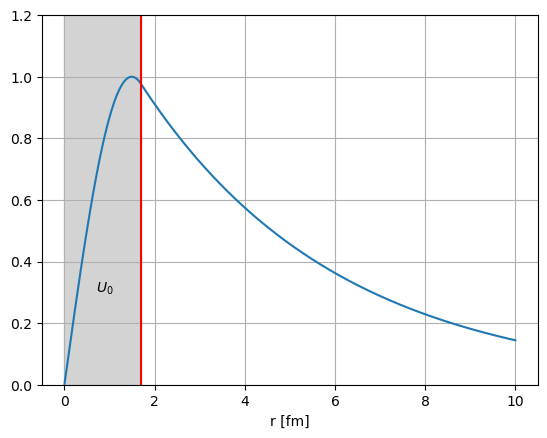

In [125]:
rs = np.linspace(0, 10, 300)
wavefunc = [full_eq(r, U_0_value) for r in rs]
plt.plot(rs, wavefunc)
plt.axvline(1.7,color='r', label="R")
plt.fill_betweenx([-2,2],[1.7,1.7], color="lightgrey")
plt.xlabel("r [fm]")
plt.annotate('$U_0$', [0.7,0.3])
plt.ylim(0, 1.2)
plt.grid()
plt.show()

# B

In [126]:
#  Python version of Jacob Johansen's square-well program   19/5-2020
#
#  The program calculates energy eigenvalues for a neutron in a square well
#  nuclear potential with radius R = 1.4 * A^(1/3) fm
#  Units  -  MeV, fm
#  Input:     all scalar
#    V0 - depth of the well in MeV
#    A  - total number of nucleons for the potential
#    l  - angular momentum
#  Output:
#    E  - energy eigenvalues

import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc

# numerical constants - PDG 2018
hbarc = 197.3269788
me = 0.510998946
mp = 938.272081
mn = 939.565413
finest = 1/137.03599914

mhbar = 2.*mn/hbarc**2

V0 = 40.
A = int(input('Give A value: '))
l = 0

# find energies in E-list just below a fullfilled matching condition
def zeropoint(E,V0,A,l):
    r0 = 1.4*A**(1./3.)
    kr = np.sqrt(mhbar*(V0-abs(E)))*r0
    kapr = np.sqrt(mhbar*abs(E))*r0
    indre = kr*sc.spherical_jn(l,kr,derivative=True)/sc.spherical_jn(l,kr)
    ydre = kapr*sc.spherical_kn(l,kapr,derivative=True)/sc.spherical_kn(l,kapr)
    egenligning = indre - ydre
    signchange = egenligning[0:len(E)-1]*egenligning[1:len(E)]
    # signchange is small and negative at matching points, but also large
    #   when "the tangent diverges"...
    eresult = []
    [eresult.append(E[i]) for i in range(len(E)-1) if signchange[i]<0 and abs(egenligning[i])<10]
    return eresult

# first find all solutions with 0.1 MeV resolution
E1 = np.linspace(-1*V0+.1,-0.1,10*int(V0)-1)
Eres = zeropoint(E1,V0,A,l)
#print(Eres)

# then refine each solution to 0.1 keV
Efinal = []
for j in range(len(Eres)):
    E2 = np.linspace(Eres[j],Eres[j]+0.1,num=1000,endpoint=False)
    Ehelp = zeropoint(E2,V0,A,l)
    Efinal.append(Ehelp[0])

print('A:',A,' V0:',V0,' l:',l)
print(Efinal)

Give A value: 25
A: 25  V0: 40.0  l: 0
[-31.278799999999997, -7.198400000000003]


In [131]:
As = np.arange(15, 250, 10)
Es = []


for A in As:
    # first find all solutions with 0.1 MeV resolution
    E1 = np.linspace(-1*V0+.1,-0.1,10*int(V0)-1)
    Eres = zeropoint(E1,V0,A,l)
    #print(Eres)

    # then refine each solution to 0.1 keV
    Efinal = []
    for j in range(len(Eres)):
        E2 = np.linspace(Eres[j],Eres[j]+0.1,num=1000,endpoint=False)
        Ehelp = zeropoint(E2,V0,A,l)
        Efinal.append(Ehelp[0])
    Es.append(Efinal)
    
    

In [153]:
df_e = pd.DataFrame({"A": As, "Energylevels": Es})

In [154]:
def expand_list(row: list) -> pd.Series:
    max_len = max(map(len, row))
    return pd.Series(row[0] + [None] * (max_len - len(row[0])))

expanded_df = df_e[["Energylevels"]].apply(expand_list, axis=1)

In [158]:
for col in expanded_df.columns:
    df_e[col] = expanded_df[col]

In [234]:
t_es = df.loc[df["A"].isin(As)].copy()
t_es["Binding Energy/A (keV)"] = t_es["Binding Energy/A (keV)"].str.replace("#", "").astype(float)
#t_es["Binding Energy/A (keV)"] = t_es["Binding Energy/A (keV)"] * t_es["A"]

In [235]:
es = [t_es.loc[t_es["A"] == A, "Binding Energy/A (keV)"].max() for A in As]

In [241]:
t_es.query("A == 105")

,N,Z,A,El,Orig,Mass Excess (keV),ME Unc,Binding Energy/A (keV),BE/A Unc,Beta-decay Type,Beta-decay Energy (keV),BE Unc,N Protons,Atomic Mass (micro-u),AM Unc
1199,67,38,105,Sr,x,-38190#,500#,8152.000,5#,B-,12380#,640#,104,959000#,540#
1200,66,39,105,Y,x,-50570#,400#,8262.000,4#,B-,10890#,400#,104,945710#,430#
1201,65,40,105,Zr,x,-61458,12,8358.600,0.12,B-,8457,13,104,934022,13
1202,64,41,105,Nb,x,-69916,4,8431.690,0.04,B-,7415,10,104,924943,4
1203,63,42,105,Mo,,-77331,9,8494.860,0.09,B-,4960,40,104,916982,10
1204,62,43,105,Tc,,-82290,40,8534.600,0.3,B-,3650,40,104,911660,40
1205,61,44,105,Ru,,-85934.5,2.5,8561.902,0.024,B-,1916.7,2.9,104,907745.5,2.7
1206,60,45,105,Rh,,-87851.3,2.5,8572.705,0.024,B-,566.6,2.3,104,905687.8,2.7
1207,59,46,105,Pd,,-88417.9,1.1,8570.651,0.011,,*,,104,905079.5,1.2
1208,58,47,105,Ag,,-87071,5,8550.370,0.04,B+,1347,5,104,906526,5


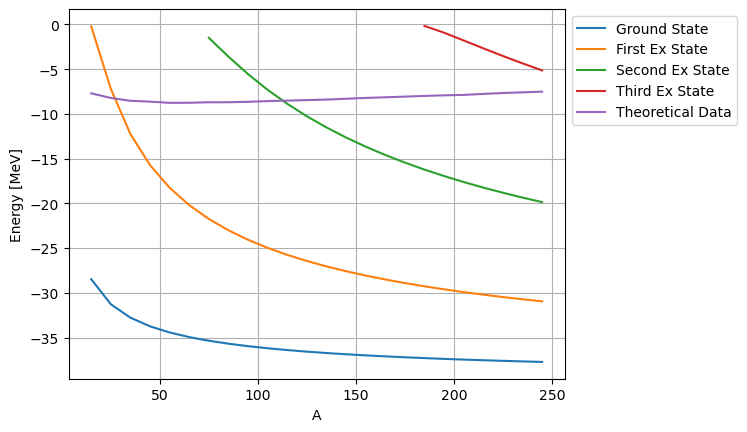

In [251]:
plt.plot(df_e["A"], df_e[0], label="Ground State")
plt.plot(df_e["A"], df_e[1], label="First Ex State")
plt.plot(df_e["A"], df_e[2], label="Second Ex State")
plt.plot(df_e["A"], df_e[3], label="Third Ex State")
plt.plot(As, np.array(es)*-1*1e-3, label="Theoretical Data")
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("A")
plt.ylabel("Energy [MeV]")
plt.grid()
plt.show()

In [197]:
df_e

,A,Energylevels,0,1,2,3
0,15,"[-28.474899999999998, -0.20830000000000426]",-28.4749,-0.2083,NaN,NaN
1,25,"[-31.278799999999997, -7.198400000000003]",-31.2788,-7.1984,NaN,NaN
2,35,"[-32.7819, -12.2561]",-32.7819,-12.2561,NaN,NaN
3,45,"[-33.7485, -15.722800000000001]",-33.7485,-15.7228,NaN,NaN
4,55,"[-34.4343, -18.2548]",-34.4343,-18.2548,NaN,NaN
5,65,"[-34.9518, -20.1981]",-34.9518,-20.1981,NaN,NaN
6,75,"[-35.3594, -21.7455, -1.4931]",-35.3594,-21.7455,-1.4931,NaN
7,85,"[-35.6907, -23.012900000000002, -3.59890000000...",-35.6907,-23.0129,-3.5989,NaN
8,95,"[-35.9664, -24.074, -5.557000000000001]",-35.9664,-24.0740,-5.5570,NaN
9,105,"[-36.200399999999995, -24.9782, -7.31059999999...",-36.2004,-24.9782,-7.3106,NaN


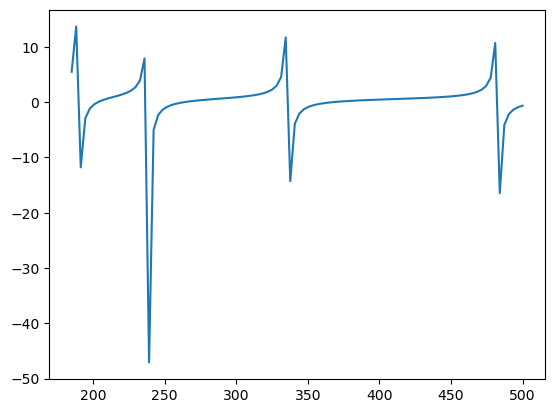

In [281]:
U_0s = np.linspace(185,500, 100)
plt.plot(U_0s, func(U_0s, 25))
#plt.xlim(40,50)
plt.show()

# C

In [257]:
def book_eq_3_47(R: float):
    """
    kR = pi/2
    and it then follows that
    """
    m = 469.48968 
    U_cr = np.pi**2 * hbarc**2 / (8 * m * R**2)
    return U_cr

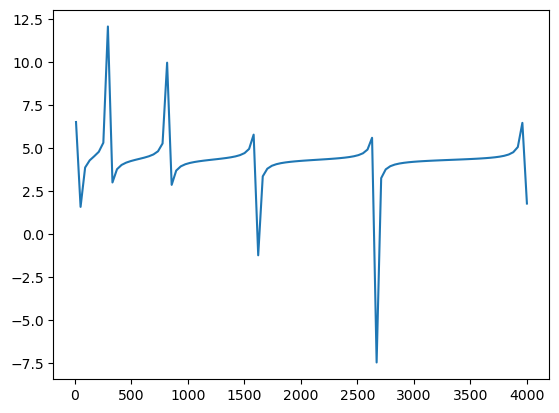

In [283]:
# It can be seen on this graph that for a higher U_0 can support a large R such kR = pi /2 
U_0s = np.linspace(10,4000, 100)
plt.plot(U_0s, func(U_0s, 2))
#plt.xlim(40,50)
plt.show()
# You can see this periodicy

In [261]:
book_eq_3_47(1.7)

35.404527153647386